In [1]:
from matplotlib import pyplot as plt
import os
import numpy as np
import pickle
from quantiphy import Quantity as Q # pip3 install quantiphy
from scipy.signal import find_peaks
%matplotlib inline

notes:

multimeter readings 

1.6 1.4 micro amp

voltage +2.448 -1.258

generator:

1.855vpp

300mv offset

In [2]:
# all data folders
all_folders = sorted([folder for folder in os.listdir() if folder.startswith("varyamp_")])
all_folders

['varyamp_1558', 'varyamp_1559', 'varyamp_1560']

In [3]:
all_folders = ['varyamp_1560','varyamp_1558']

In [4]:
%%time
datafolder = "varyamp_1560/"
raw_data=[]
for file in os.listdir(datafolder)[:10]:
    data = ""
    with open(f"{datafolder}{file}","r") as f:
        data = f.readlines()
    raw_data.append( [int(d.split(",")[0]) for d in data[25:]] )
raw_data = np.array(raw_data)

Wall time: 77.5 ms


In [5]:
header = data[:25]
header

['Format,1.0B,\n',
 'Memory Length,10000,Memory Length,10000,\n',
 'IntpDistance,0,IntpDistance,0,\n',
 'Trigger Address,4999,Trigger Address,4999,\n',
 'Trigger Level,1.040E+00,Trigger Level,1.040E+00,\n',
 'Source,CH1,Source,CH2,\n',
 'Vertical Units,V,Vertical Units,V,\n',
 'Vertical Units Div,0,Vertical Units Div,0,\n',
 'Vertical Units Extend Div,16,Vertical Units Extend Div,16,\n',
 'Label,,Label,,\n',
 'Probe Type,0,Probe Type,0,\n',
 'Probe Ratio,1.000e+01,Probe Ratio,1.000e+00,\n',
 'Vertical Scale,5.000e-01,Vertical Scale,1.000e+00,\n',
 'Vertical Position,-1.820e+00,Vertical Position,0.000e+00,\n',
 'Horizontal Units,S,Horizontal Units,S,\n',
 'Horizontal Scale,2.000E-05,Horizontal Scale,2.000E-05,\n',
 'Horizontal Position,0.000E+00,Horizontal Position,0.000E+00,\n',
 'Horizontal Mode,Main,Horizontal Mode,Main,\n',
 'SincET Mode,Real Time,SincET Mode,Real Time,\n',
 'Sampling Period,2.000e-08,Sampling Period,2.000e-08,\n',
 'Horizontal Old Scale,2.000E-05,Horizontal Old Sca

In [6]:
scope_settings = [d[:-2] for i,d in list(enumerate(data)) if i in [4,12,13,15,19]]
print(scope_settings)
trigger_level = float(data[4].split(",")[1])
vert_scale = float(data[12].split(",")[1])
vert_pos = float(data[13].split(",")[1])
trigger_level,vert_scale,vert_pos,np.max(raw_data),np.min(raw_data)

['Trigger Level,1.040E+00,Trigger Level,1.040E+00', 'Vertical Scale,5.000e-01,Vertical Scale,1.000e+00', 'Vertical Position,-1.820e+00,Vertical Position,0.000e+00', 'Horizontal Scale,2.000E-05,Horizontal Scale,2.000E-05', 'Sampling Period,2.000e-08,Sampling Period,2.000e-08']


(1.04, 0.5, -1.82, 100, -2)

In [7]:
%%time
tempdatafile = "proc_temp_data/read03_readdata.pkl"
raw_data_list = []
rerun = False
if rerun or not tempdatafile in os.listdir("proc_temp_data/"):
    for i,datafolder in enumerate(all_folders):
        raw_data1=[];raw_data2=[];
        for file in sorted(os.listdir(datafolder))[:-1]:
            data = ""
            with open(f"{datafolder}/{file}","r") as f:
                data = f.readlines()
            raw_data1.append( [int(d.split(",")[0]) for d in data[25:]])
            raw_data2.append( [int(d.split(",")[2]) for d in data[25:]]) 
        raw_data = np.array(raw_data1),np.array(raw_data2)
        raw_data_list.append( (datafolder,raw_data,data) )
    pickle.dump(raw_data_list,open(tempdatafile,"wb"))
else:
    raw_data_list = pickle.load(open(tempdatafile,"rb"))
print("done reading data")

done reading data
Wall time: 1min 57s


In [8]:
def get_scopesettings(data):
    scope_settings = [d[:-2] for i,d in list(enumerate(data)) if i in [4,12,13,15,19]]
    trigger_level = float(data[4].split(",")[1])
    vert_scale = float(data[12].split(",")[1])
    vert_pos = float(data[13].split(",")[1])
    hori_scale = float(data[15].split(",")[1])
    sample_period = float(data[19].split(",")[1])
    return scope_settings,trigger_level,vert_scale,vert_pos,hori_scale,sample_period

In [9]:
led_data = []
apd_data = []
for i,_ in enumerate(all_folders):
    datafolder, raw_data,data = raw_data_list[i]
    led_data.append(raw_data[1])
    apd_data.append(raw_data[0])
led_data = np.vstack(led_data)
apd_data = np.vstack(apd_data)

In [10]:
i=0
datafolder, raw_data,data = raw_data_list[i]
scope_settings,trigger_level,vert_scale,vert_pos,hori_scale,sample_period = get_scopesettings(data)

Wall time: 16.5 s


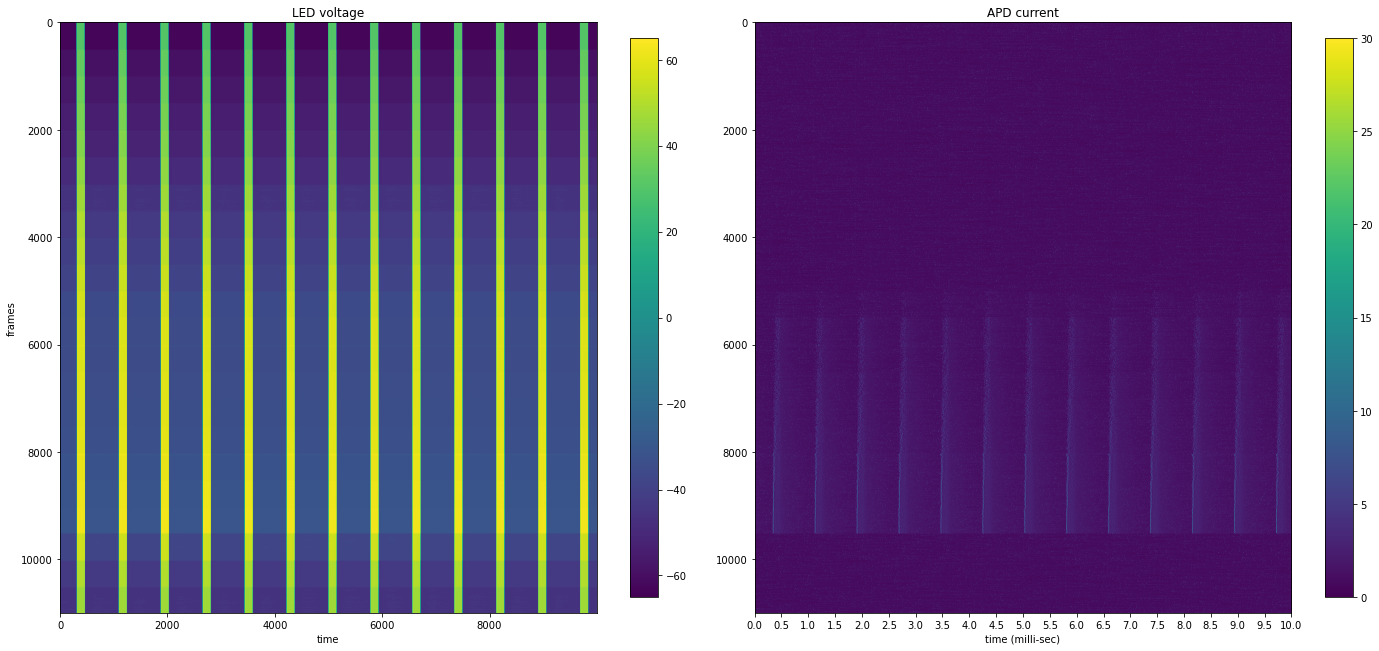

In [11]:
%%time
fig,axx = plt.subplots(1,2,figsize=(20,10))
ax=axx[0]
im=ax.imshow(led_data,interpolation=None)
plt.colorbar(im,ax=ax,shrink=0.8)
ax.set_title("LED voltage")
ax.set_xlabel("time")
ax.set_ylabel("frames")

ax=axx[1]
im=ax.imshow(np.clip(apd_data,0,30),interpolation=None)
plt.colorbar(im,ax=ax,shrink=0.8)
ax.set_title("APD current")
ax.set_xlabel("time (milli-sec)")
num_xticks = 20
ax.set_xticks(np.arange(0,len(led_data[0])+1,len(led_data[0])//num_xticks))
ax.set_xticklabels([i/1000 for i in np.arange(0,len(led_data[0])+1,len(led_data[0])//num_xticks)])

plt.tight_layout()
plt.savefig("results03_01_apdvoltage.png",dpi=300)

### average time before each trigger

In [12]:
scope_settings

['Trigger Level,1.040E+00,Trigger Level,1.040E+00',
 'Vertical Scale,5.000e-01,Vertical Scale,1.000e+00',
 'Vertical Position,-1.820e+00,Vertical Position,0.000e+00',
 'Horizontal Scale,2.000E-05,Horizontal Scale,2.000E-05',
 'Sampling Period,2.000e-08,Sampling Period,2.000e-08']

freq=64kHz

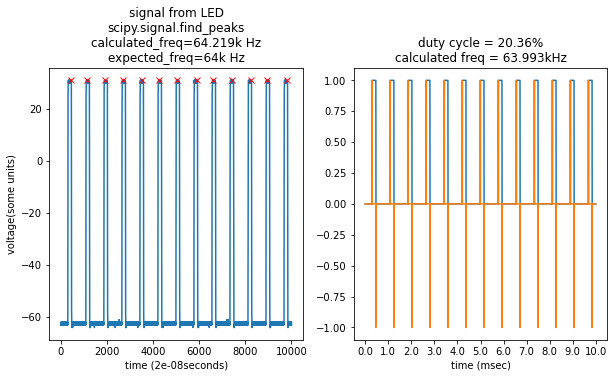

In [13]:
fig,axx = plt.subplots(1,2,figsize=(10,5))
ax=axx[0]
peak_x , peak_heights = find_peaks(led_data[0],height=10,distance=200)
ax.plot(led_data[0],alpha=1)
ax.plot(peak_x,peak_heights["peak_heights"],"x",c="r",alpha=0.96)
average_pixels_per_cycle=np.mean(np.diff(peak_x))
calculated_freq = 1/(sample_period*average_pixels_per_cycle)
expected_freq =64000
diff = np.diff(1*(led_data[0]>np.mean(led_data[0])))

ax.set_ylabel("voltage(some units)")
ax.set_title("signal from LED\nscipy.signal.find_peaks\n"+f"calculated_freq={Q(calculated_freq)} Hz\nexpected_freq={Q(expected_freq)} Hz")
ax.set_xlabel(f"time ({sample_period}seconds)")
ax=axx[1]
time_x = np.arange(len(led_data[0]))*sample_period
time_on = np.mean(np.where(diff==-1)[0] - np.where(diff==1)[0])
time_off = np.mean(np.where(diff==1)[0][1:]-np.where(diff==-1)[0][:-1])
ax.plot(time_x,led_data[0]>np.mean(led_data[0]))
ax.plot(time_x[:-1],diff)
num_xticks = 10
ax.set_xticks(np.arange(0,len(led_data[0])+1,len(led_data[0])//num_xticks)*sample_period)
ax.set_xticklabels([i/1000 for i in np.arange(0,len(led_data[0])+1,len(led_data[0])//num_xticks)])
ax.set_xlabel("time (msec)")
ax.set_title(f"duty cycle = {time_on/(time_off+time_on)*100:.2f}%\n"
             f"calculated freq = {Q(1/sample_period/np.mean(np.diff(np.where(diff==-1)[0])))}Hz")
plt.savefig("results03_02_ledvoltage.png")

## todo, find the time intervals between peaks

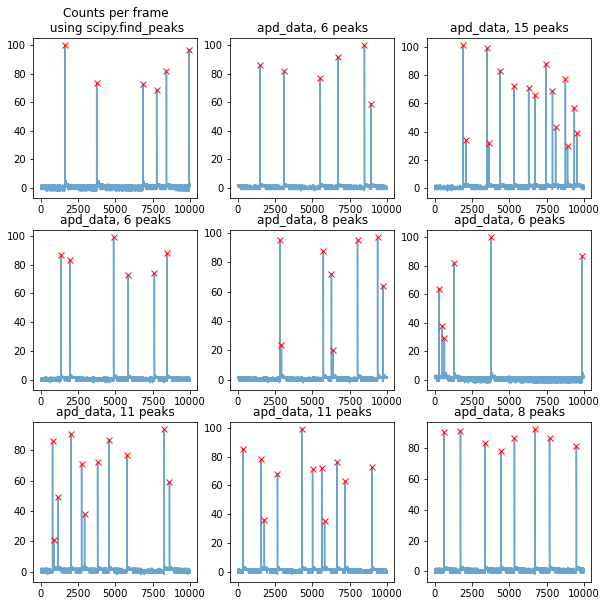

In [14]:
fig,axx = plt.subplots(3,3,figsize=(10,10))
axx=axx.ravel()
for framei,ax in enumerate(axx):
    framei += 300
    peak_x , peak_heights = find_peaks(apd_data[framei],height=10)#,width=2)
    ax.plot(apd_data[framei],alpha=0.66)
    ax.plot(peak_x,peak_heights["peak_heights"],"x",c="r",alpha=0.96)
    ax.set_title(f"apd_data, {len(peak_x)} peaks")
axx[0].set_title("Counts per frame\n using scipy.find_peaks")
plt.savefig("results03_03_darkcounts.png")

Wall time: 670 ms


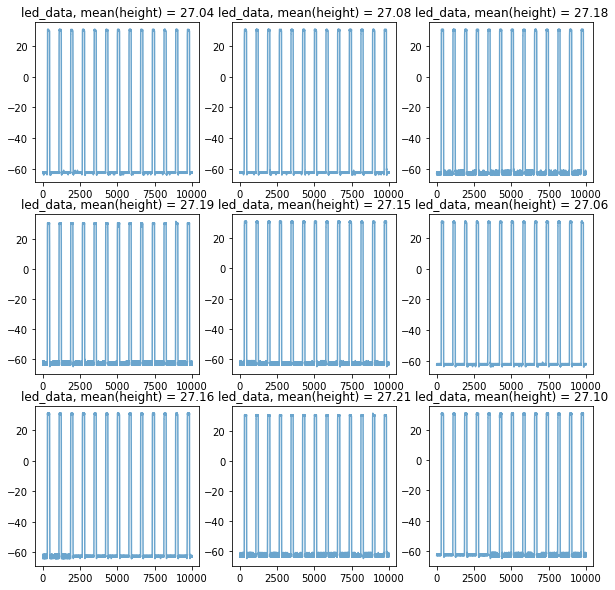

In [15]:
%%time
fig,axx = plt.subplots(3,3,figsize=(10,10))
for framei,ax in enumerate(axx.ravel()):
    framei += 300
    ax.plot(led_data[framei],alpha=0.66)
    meanheight= np.mean(led_data[framei][np.where(led_data[framei]>np.mean(led_data[framei]))])
    ax.set_title(f"led_data, mean(height) = { meanheight :.2f}")
plt.savefig("results03_04_led_voltage.png")

In [16]:
%%time
darkcounts =[]
average_peak_led = []
for framei in range(len(apd_data)):
    peak_x , peak_heights = find_peaks(apd_data[framei],height=10)
    darkcounts .append(len(peak_x))
    meanheight= np.mean(led_data[framei][np.where(led_data[framei]>np.mean(led_data[framei]))])
    average_peak_led.append( meanheight )

Wall time: 1.74 s


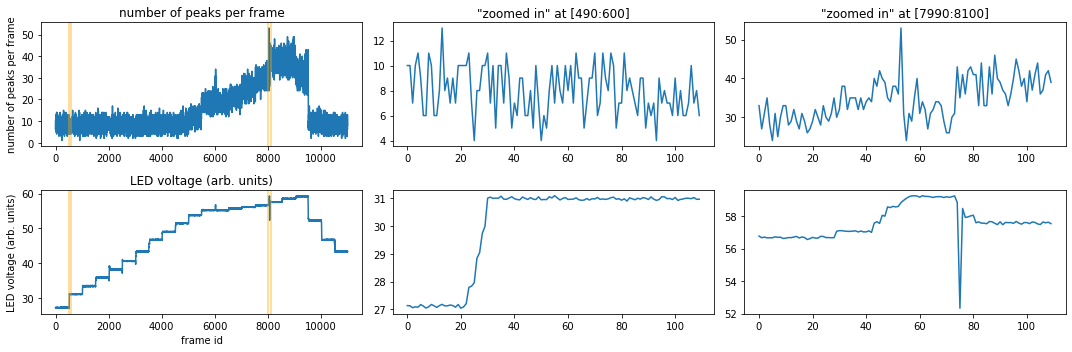

In [17]:
fig,axx = plt.subplots(2,3,figsize=(15,5))

ax = axx[0,0]
ax.plot(darkcounts)
ax.set_ylabel("number of peaks per frame")
ax.set_title("number of peaks per frame")
ax = axx[1,0]
ax.plot(average_peak_led)
ax.set_ylabel("LED voltage (arb. units)")
ax.set_title("LED voltage (arb. units)")
ax.set_xlabel("frame id")

ax = axx[0,1]
ax.set_title('"zoomed in" at [490:600]')
ax.plot(darkcounts[490:600])
ax = axx[1,1]
ax.plot(average_peak_led[490:600]) 

ax = axx[0,2]
ax.set_title('"zoomed in" at [7990:8100]')
ax.plot(darkcounts[7990:8100])
ax = axx[1,2]
ax.plot(average_peak_led[7990:8100]) 
for i in [0,1]:
    axx[i,0].axvline(490,color="orange",alpha=0.5)
    axx[i,0].axvline(600,color="orange",alpha=0.5)
    axx[i,0].axvline(7990,color="orange",alpha=0.5)
    axx[i,0].axvline(8100,color="orange",alpha=0.5)
plt.tight_layout()
plt.savefig("results03_05_averaged_crosssection_of_data.png")

### retrieving windows when LED voltage is stable

In [18]:
from collections import OrderedDict
good_frames =OrderedDict() 
minled = np.inf; maxled = -np.inf
for i in range(len(average_peak_led)//500):
    roi_led = average_peak_led[90+i*500:490+i*500]
    roi_darkcounts = darkcounts[90+i*500:490+i*500]
    roi_apd = apd_data[80+i*500:490+i*500]
    minled = min(minled,np.median(roi_led)) ; maxled = max(maxled,np.median(roi_led)) 
    good_frames[f"{np.mean(roi_led):.5f}"] = {"led":roi_led,"roi_darkcounts":roi_darkcounts,"roi_apd":roi_apd}

Wall time: 1.05 s


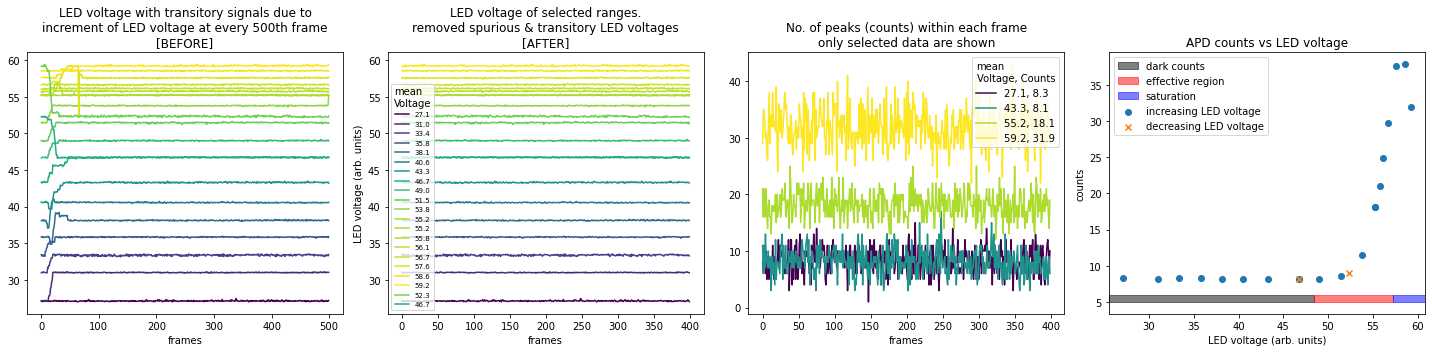

In [19]:
%%time

fig,axx = plt.subplots(1,4,figsize=(20,5))
for i in range(len(average_peak_led)//500):
    roi_led = average_peak_led[90+i*500:490+i*500]
    roi_darkcounts = darkcounts[90+i*500:490+i*500]
    medianled=np.mean(roi_led)
    axx[1].plot(roi_led,c=plt.cm.viridis((medianled-minled)/(maxled-minled)),label=f"{medianled:.1f}") 
    axx[0].plot(average_peak_led[i*500:500+i*500],c=plt.cm.viridis((medianled-minled)/(maxled-minled)))
    if i % 6==0:
        axx[2].plot(roi_darkcounts,label=f"{medianled:.1f}, {np.mean(roi_darkcounts):.1f}",c=plt.cm.viridis((medianled-minled)/(maxled-minled)))
axx[2].legend(title="mean\nVoltage, Counts")
axx[2].set_title("No. of peaks (counts) within each frame\nonly selected data are shown")
axx[2].set_xlabel("frames")
axx[1].legend(title="mean\nVoltage",fontsize=7)
axx[1].set_title("LED voltage of selected ranges.\nremoved spurious & transitory LED voltages\n[AFTER]")
axx[1].set_ylabel("LED voltage (arb. units)")
axx[1].set_xlabel("frames")

axx[0].set_title("LED voltage with transitory signals due to\nincrement of LED voltage at every 500th frame\n[BEFORE]")
axx[0].set_xlabel("frames")
avg_counts_temp= [ ];avg_led_temp=[]
for led,dictt in good_frames.items():
    avg_counts_temp.append(float(np.mean(dictt["roi_darkcounts"])))
    avg_led_temp.append(float(led))
ax=axx[3]    
ax.scatter(avg_led_temp[:-2],avg_counts_temp[:-2],marker="o",label="increasing LED voltage")
ax.scatter(avg_led_temp[-2:],avg_counts_temp[-2:],marker="x",label="decreasing LED voltage") 
ax.axhspan(5,6,0,0.65,color="k",alpha=0.5,label="dark counts")
ax.axhspan(5,6,0.65,0.90,color="r",alpha=0.5,label="effective region")
ax.axhspan(5,6,0.90,1,color="b",alpha=0.5,label="saturation")
ax.legend()
ax.set_ylabel("counts")
ax.set_xlabel("LED voltage (arb. units)")
ax.set_title("APD counts vs LED voltage")
plt.tight_layout()
plt.savefig("results03_06_ledvoltagelevels_selection.png",dpi=150)

### getting the poisson statistics of counts

Each frame as an interval of 10 milli seconds in real time.

On average, x peaks are present in each frame (averaged over 400 frames)

Assuming the peaks are independent of each other, x should follow a poisson distribution

In [20]:
%%time
roi_darkcounts = [good_frames[key]["roi_darkcounts"] for key in good_frames.keys() if float(key)<45]
roi_darkcounts = np.array(roi_darkcounts).reshape(-1)

peak_vec_x = []
peak_vec_height = []
for key in good_frames.keys():
    if float(key)>=45:
        continue
    for i in range(len(good_frames[key]['roi_apd'])):
        roi_apd=good_frames[key]['roi_apd'][i]
        peak_x , peak_heights = find_peaks(roi_apd,height=10)
        for _x,_y in zip(np.diff(peak_x),np.diff(peak_heights["peak_heights"])):
            peak_vec_x.append(_x)
            peak_vec_height.append(_y)

Wall time: 278 ms


In [23]:
good_frames.keys()

odict_keys(['27.11306', '30.99287', '33.36449', '35.83639', '38.11467', '40.55258', '43.29724', '46.72126', '49.00428', '51.46791', '53.77853', '55.22375', '55.21089', '55.75713', '56.14086', '56.65644', '57.58026', '58.55233', '59.22299', '52.32537', '46.71663'])

Wall time: 683 ms


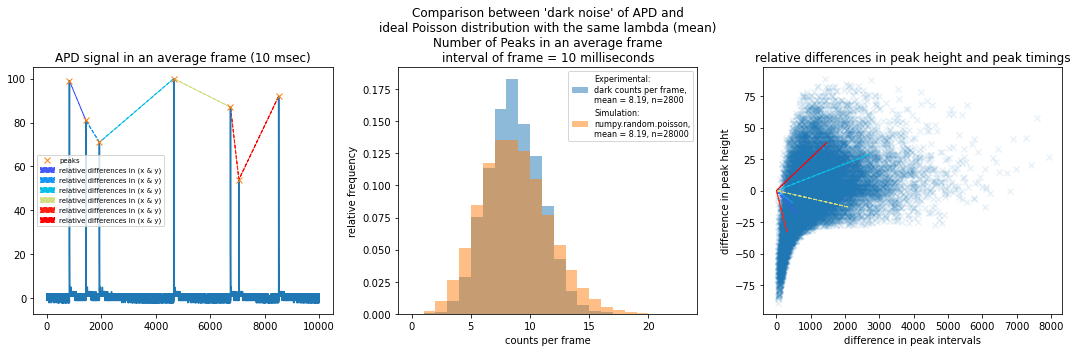

In [24]:
%%time 
fig,axx = plt.subplots(1,3,figsize=(15,5))

ax=axx[0]
handles = [];labels=[]
roi_apd=good_frames["38.11467"]['roi_apd'][4]
ax.plot(roi_apd)
peak_x , peak_heights = find_peaks(roi_apd,height=10)
plothandle, = ax.plot(peak_x,peak_heights["peak_heights"],"x",label="peaks")
handles.append(plothandle);labels.append("peaks")
for _x,_y,_dx,_dy in zip(peak_x[:-1],peak_heights["peak_heights"][:-1],
                         np.diff(peak_x),np.diff(peak_heights["peak_heights"])):
    arrows = ax.arrow(_x,_y,_dx,_dy,color=plt.cm.rainbow(_x/max(peak_x[:-1])),ls="--")
    handles.append(arrows);labels.append("relative differences in (x & y)")
ax.set_title("APD signal in an average frame (10 msec)")
ax.legend(handles,labels,fontsize=7,loc="center left")

ax=axx[1]
ax.set_title("Comparison between 'dark noise' of APD and\nideal Poisson distribution with the same lambda (mean)\n"+
             "Number of Peaks in an average frame\n"+
            "interval of frame = 10 milliseconds")
ax.hist(roi_darkcounts,bins=np.arange(min(roi_darkcounts),max(roi_darkcounts)+1),
         label=f"Experimental:\ndark counts per frame,\nmean = {np.mean(roi_darkcounts):.2f}, n={len(roi_darkcounts)}",density=True,alpha=0.5);
rand = np.random.poisson(np.mean(roi_darkcounts),size=len(roi_darkcounts)*10)
ax.hist(rand,bins=np.arange(min(rand),max(rand)+1),
         label=f"Simulation:\nnumpy.random.poisson,\nmean = {np.mean(roi_darkcounts):.2f}, n={len(roi_darkcounts)*10}",density=True,alpha=0.5);
ax.legend(fontsize=8)
ax.set_ylabel("relative frequency")
ax.set_xlabel("counts per frame")

ax=axx[2]

ax.scatter(np.array(peak_vec_x).reshape(-1),np.array(peak_vec_height).reshape(-1),marker="x",alpha=0.1)

for _x,_y,_dx,_dy in zip(peak_x[:-1],peak_heights["peak_heights"][:-1],
                         np.diff(peak_x),np.diff(peak_heights["peak_heights"])):
    ax.arrow(0,0,_dx,_dy,color=plt.cm.rainbow(_x/max(peak_x[:-1])),label="he",ls="--")
ax.set_title("relative differences in peak height and peak timings")
ax.set_ylabel("difference in peak height")
ax.set_xlabel("difference in peak intervals")
plt.tight_layout()
plt.savefig("results03_07_distribution_of_peaks.png",dpi=150)

In [22]:
15000 # cps counts per sec (sap500 dark count rate)

15000